# Import Dependensi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numpy import hstack
import tensorflow as tf
from numpy import array
from datetime import datetime, timedelta
import matplotlib as mpl
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization, Activation
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Matplotlib created a temporary cache directory at /var/folders/86/7gxks06s07xch2nsjg8bfzhh0000gn/T/matplotlib-mbywb4lg because the default path (/Users/ingwerludwig/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Load Dataset Baru

In [2]:
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
excel_path = os.path.join(parent_dir, 'Fix Data_Model Welang.xlsx')

In [3]:
merge_df = pd.read_excel(excel_path)
merge_df.drop('Unnamed: 0',axis=1,inplace=True)
merge_df['DateTime'] = pd.to_datetime(merge_df['DateTime'])
merge_df.sort_values(by='DateTime',ascending=True,inplace=True)
merge_df

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292
...,...,...,...,...,...
8628,2023-09-15 08:00:00,0.0,0.0,0.070,0.213
8629,2023-09-15 09:00:00,0.0,0.0,0.080,0.228
8630,2023-09-15 10:00:00,0.0,0.0,0.089,0.237
8631,2023-09-15 11:00:00,0.0,0.0,0.096,0.245


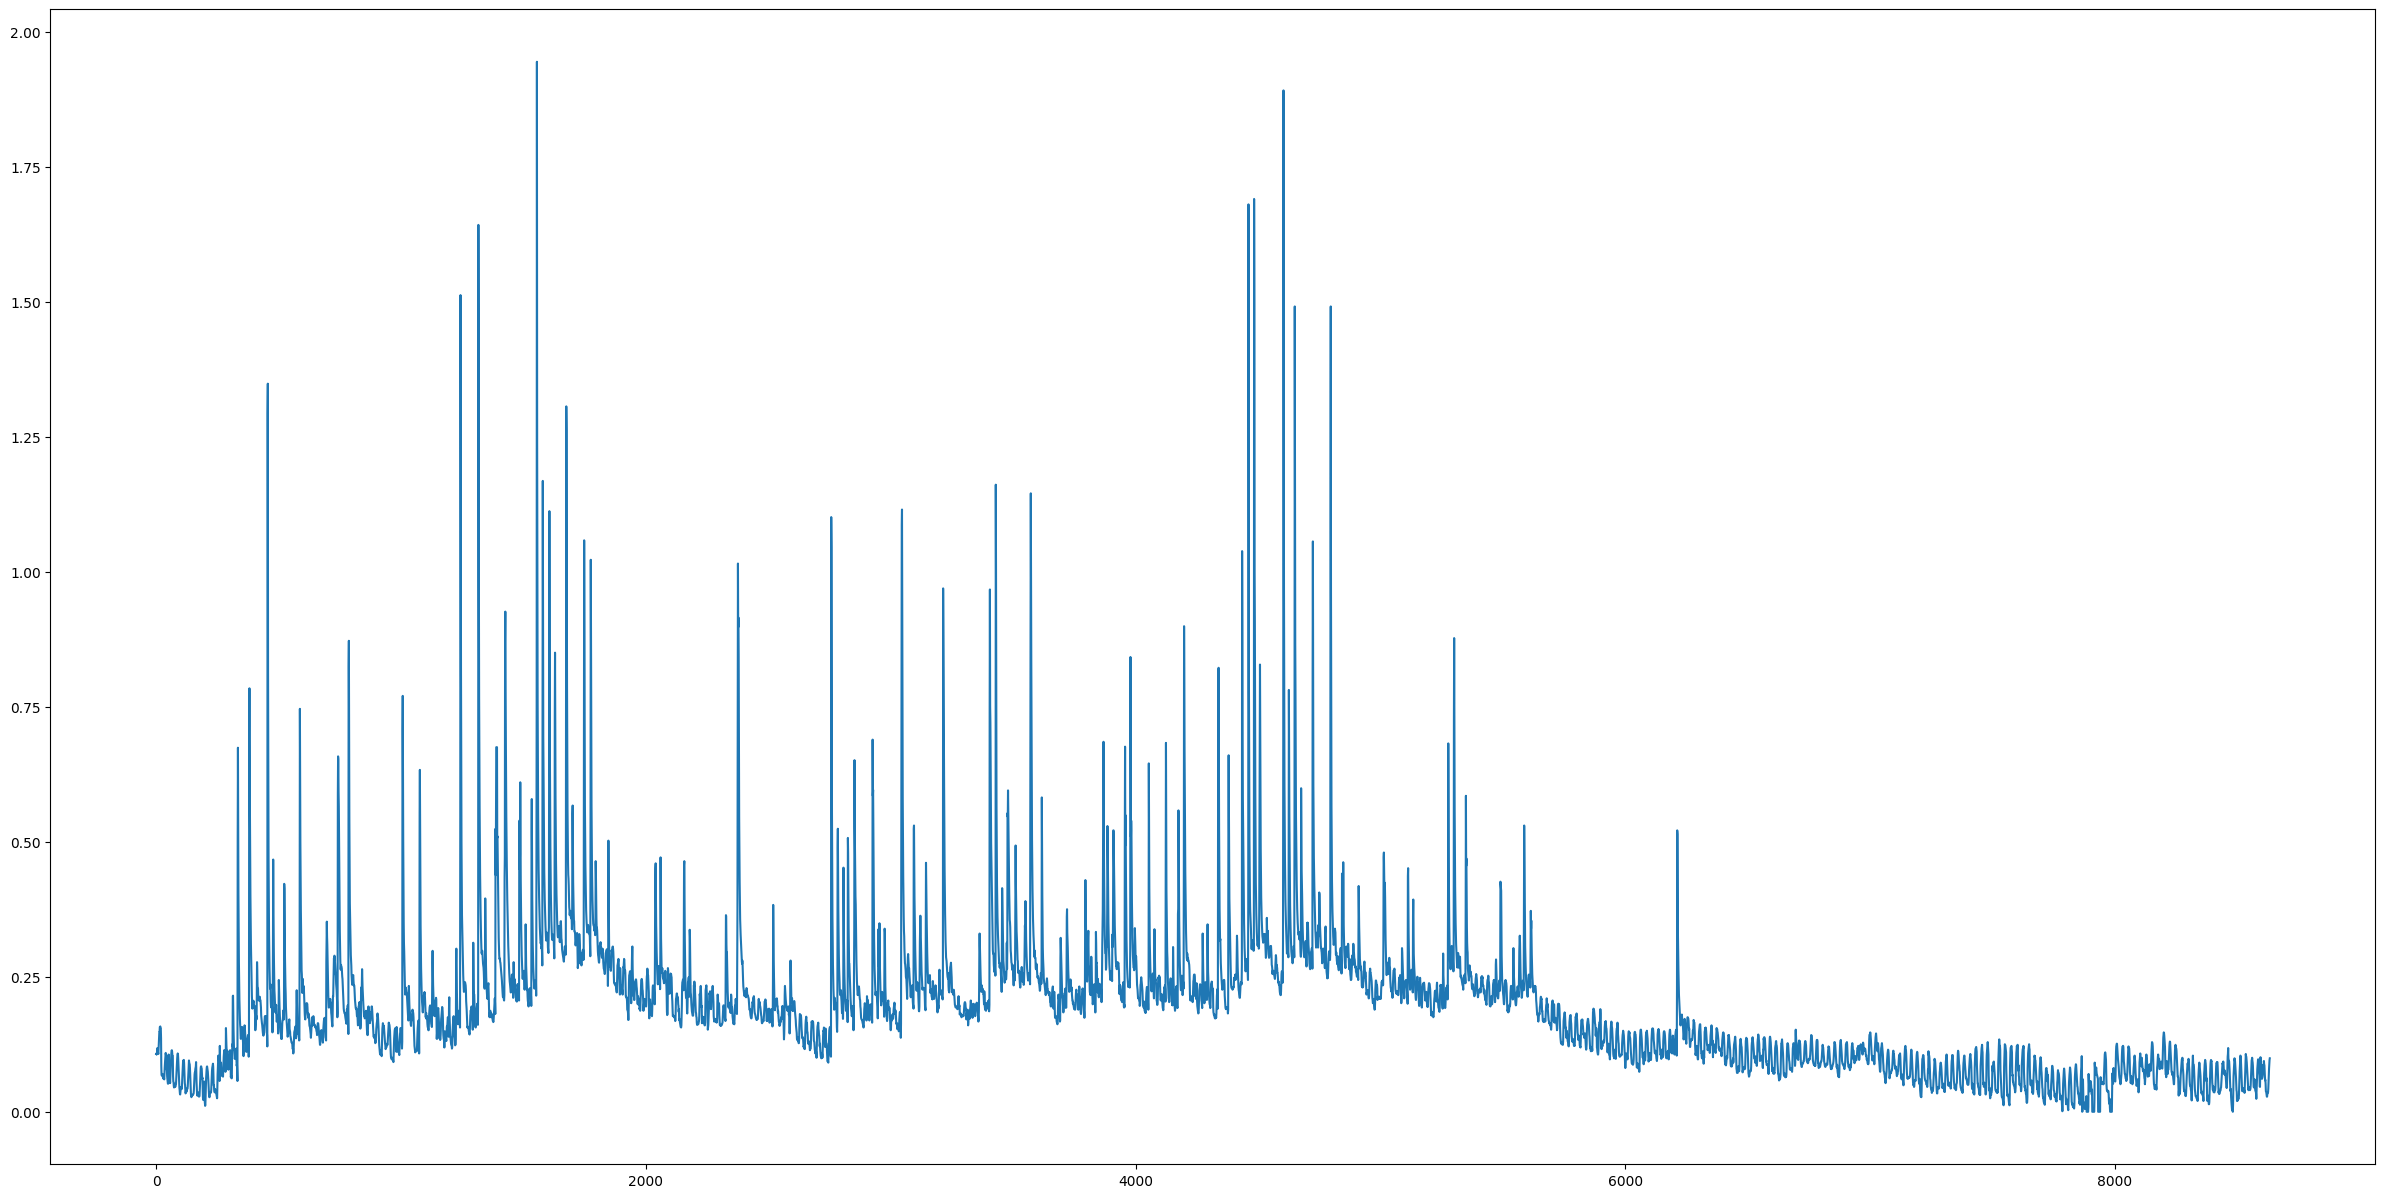

In [4]:
plt.figure(figsize=(30, 15))
plt.plot(merge_df['LP'])

# Cek data dengan nilai 0 selain di Curah Hujan

In [5]:
columns_to_replace = [
    'LP',
    'LD'
]

mask = (merge_df[columns_to_replace] == 0).any(axis=1)
filtered_rows = merge_df[mask]
filtered_rows.sort_values(by='DateTime')

,DateTime,RC,RL,LP,LD
7866,2023-08-14 14:00:00,0.0,0.0,0.0,0.179
7884,2023-08-15 08:00:00,0.0,0.0,0.0,0.196
7885,2023-08-15 09:00:00,0.0,0.0,0.0,0.201
7886,2023-08-15 10:00:00,0.0,0.0,0.0,0.202
7887,2023-08-15 11:00:00,0.0,0.0,0.0,0.199
7888,2023-08-15 12:00:00,0.0,0.0,0.0,0.197
7889,2023-08-15 13:00:00,0.0,0.0,0.0,0.193
7890,2023-08-15 14:00:00,0.0,0.0,0.0,0.189
7907,2023-08-16 07:00:00,0.0,0.0,0.0,0.180
7908,2023-08-16 08:00:00,0.0,0.0,0.0,0.177


# Visualisasi Tren

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
copy_df_2 = merge_df.iloc[48:144,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'

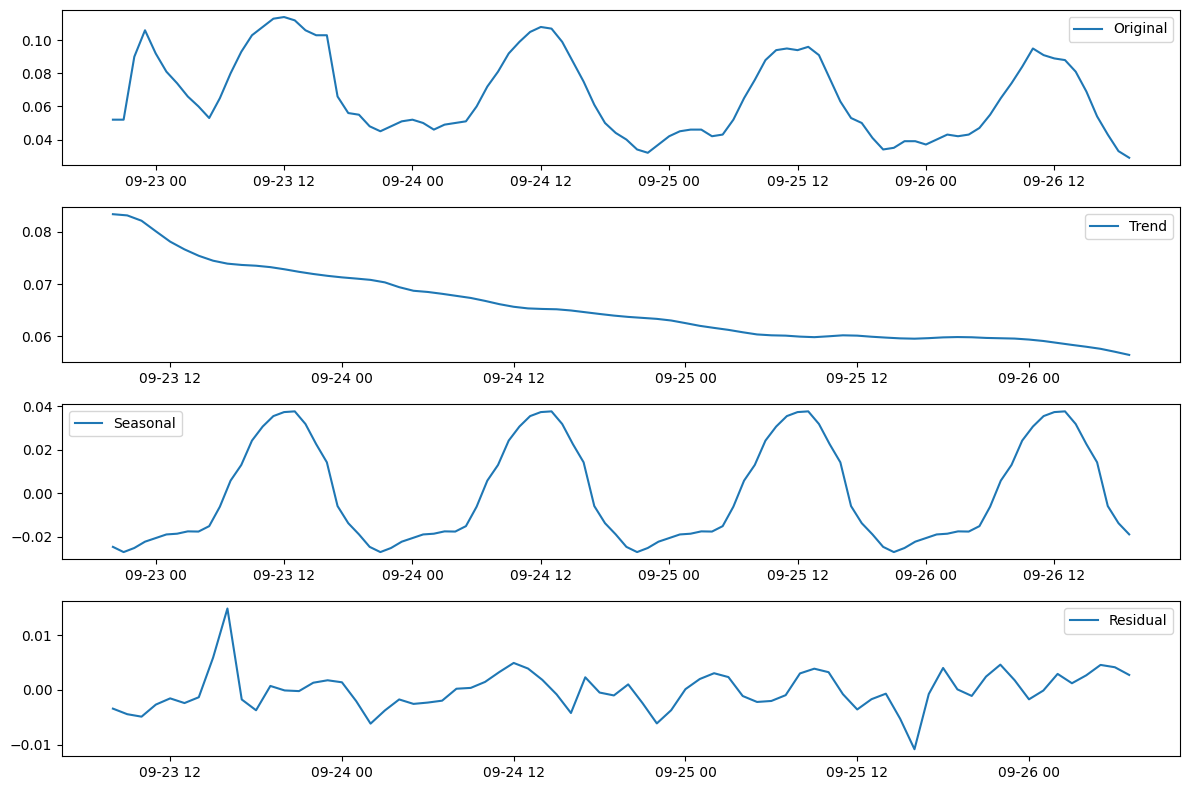

In [7]:
results = seasonal_decompose(copy_df_2['LP'])

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(copy_df_2['LP'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(results.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(results.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


# Ekstrak Fitur Datetime untuk digunakan dalam TimeSeries Forecasting

In [8]:
test = merge_df.iloc[0:1,0]
test

0   2022-09-20 20:00:00
Name: DateTime, dtype: datetime64[ns]

In [9]:
print(test.dt.hour)

0    20
Name: DateTime, dtype: int32


In [10]:
merge_df['hour_at'] = merge_df['DateTime'].dt.hour
merge_df

,DateTime,RC,RL,LP,LD,hour_at
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315,20
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307,21
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297,22
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293,23
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292,0
...,...,...,...,...,...,...
8628,2023-09-15 08:00:00,0.0,0.0,0.070,0.213,8
8629,2023-09-15 09:00:00,0.0,0.0,0.080,0.228,9
8630,2023-09-15 10:00:00,0.0,0.0,0.089,0.237,10
8631,2023-09-15 11:00:00,0.0,0.0,0.096,0.245,11


# Visualisasi Jam Terhadap Rerata Muka Air Purwodadi

Text(0, 0.5, 'Rerata Tinggi Muka Air Purwodadi')

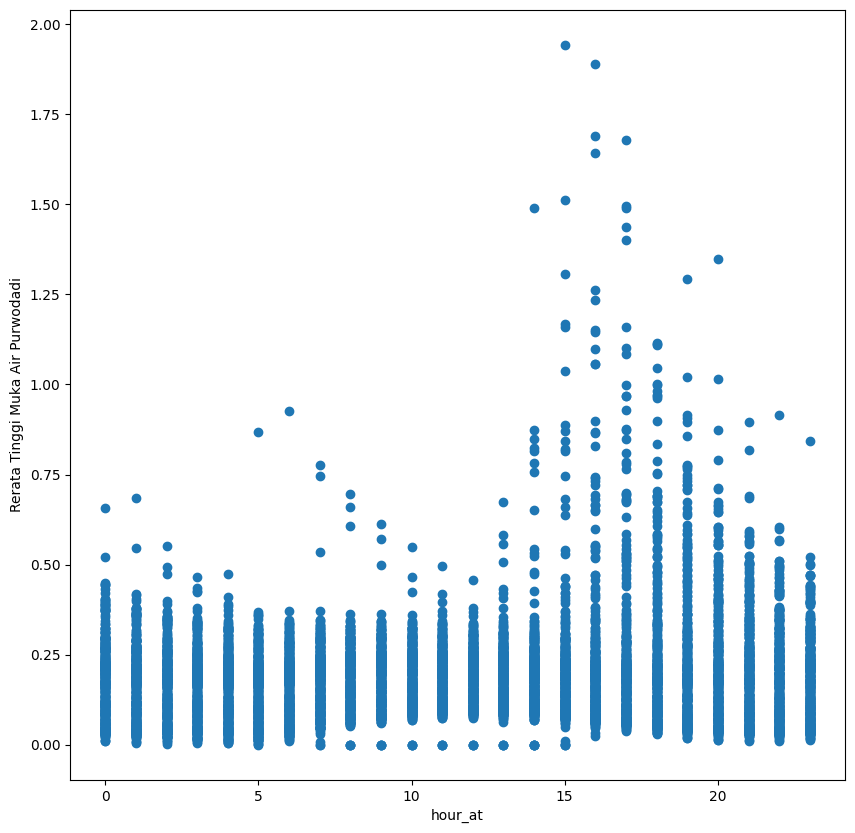

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(x='hour_at',y='LP',data=merge_df)
plt.xlabel('hour_at')
plt.ylabel('Rerata Tinggi Muka Air Purwodadi')

# Mutivariat Sekuens untuk Input dan Output LSTM

In [12]:
def split_sequences_sliding(sequences, n_steps_in, n_steps_out, step=1):
    X, y = list(), list()
    for i in range(0, len(sequences) - n_steps_in - n_steps_out + 1, step):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [13]:
merge_df.drop(['DateTime','hour_at','LD'],axis=1,inplace=True)
merge_df

,RC,RL,LP
0,0.0,0.0,0.107
1,0.0,0.0,0.108
2,0.0,0.0,0.106
3,0.0,0.0,0.108
4,0.0,0.0,0.111
...,...,...,...
8628,0.0,0.0,0.070
8629,0.0,0.0,0.080
8630,0.0,0.0,0.089
8631,0.0,0.0,0.096


# Apply Sliding Window

In [14]:
n_steps_in, n_steps_out = 3, 3
train_percent, validation_percent = 0.7, 0.2

x_data, y_data = split_sequences_sliding(merge_df.to_numpy(), n_steps_in, n_steps_out)

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
x_for_training_and_val, x_test, y_for_training_and_val, y_test = train_test_split(x_data, y_data, test_size=1-train_percent-validation_percent)
x_train, x_validation, y_train, y_validation = train_test_split(x_for_training_and_val, y_for_training_and_val, test_size=0.23)

In [16]:
y_test = y_test[:, :, -1].reshape(-1, n_steps_out)
y_train = y_train[:, :, -1].reshape(-1, n_steps_out)
y_validation = y_validation[:, :, -1].reshape(-1, n_steps_out)

In [17]:
print('Data for train:', x_train.shape, y_train.shape)
print('Total days for train:', x_train.shape[0] / 24)
print('\nData for validation:', x_validation.shape, y_validation.shape)
print('Total days for validation:', x_validation.shape[0]  / 24)
print('\nData for test:', x_test.shape, y_test.shape)
print('Total days for test:', x_test.shape[0]  / 24)

Data for train: (5979, 3, 3) (5979, 3)
Total days for train: 249.125

Data for validation: (1786, 3, 3) (1786, 3)
Total days for validation: 74.41666666666667

Data for test: (863, 3, 3) (863, 3)
Total days for test: 35.958333333333336


# Scaling

In [18]:
from sklearn.preprocessing import StandardScaler

x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_validation_reshaped = x_validation.reshape(-1, x_validation.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])

x_scaler = StandardScaler()
x_scaler.fit(x_train_reshaped)

x_train_scaled = x_scaler.transform(x_train_reshaped).reshape(x_train.shape)
x_validation_scaled = x_scaler.transform(x_validation_reshaped).reshape(x_validation.shape)
x_test_scaled = x_scaler.transform(x_test_reshaped).reshape(x_test.shape)

y_train_reshaped = y_train
y_validation_reshaped = y_validation
y_test_reshaped = y_test

y_scaler = StandardScaler()
y_scaler.fit(y_train_reshaped)

y_train_scaled = y_scaler.transform(y_train_reshaped)
y_validation_scaled = y_scaler.transform(y_validation_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [19]:
print('Data for train:', x_train_scaled.shape, y_train_scaled.shape)
print('Total days for train:', x_train_scaled.shape[0] / 24)
print('\nData for validation:', x_validation_scaled.shape, y_validation_scaled.shape)
print('Total days for validation:', x_validation_scaled.shape[0] / 24)
print('\nData for test:', x_test_scaled.shape, y_test_scaled.shape)
print('Total days for test:', x_test_scaled.shape[0] / 24)

Data for train: (5979, 3, 3) (5979, 3)
Total days for train: 249.125

Data for validation: (1786, 3, 3) (1786, 3)
Total days for validation: 74.41666666666667

Data for test: (863, 3, 3) (863, 3)
Total days for test: 35.958333333333336


In [20]:
print('Total features:', 3)
print('Total train data:', x_train_scaled.shape)
print('Total validation data:', x_validation_scaled.shape)
print('Total test data:', x_test_scaled.shape)

Total features: 3
Total train data: (5979, 3, 3)
Total validation data: (1786, 3, 3)
Total test data: (863, 3, 3)


In [21]:
print('Total features:', 3)
print('Total train data:', y_train_scaled.shape)
print('Total validation data:', y_validation_scaled.shape)
print('Total test data:', y_test_scaled.shape)

Total features: 3
Total train data: (5979, 3)
Total validation data: (1786, 3)
Total test data: (863, 3)


# Training Model

In [22]:
model = Sequential()

model.add(TCN(300, input_shape=(n_steps_in, 3)))
model.add(RepeatVector(n_steps_out))
model.add(TCN(300, return_sequences=True))
model.add(Activation('relu'))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 300)               2977500   
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 300)            0         
 r)                                                              
                                                                 
 tcn_1 (TCN)                 (None, 3, 300)            3243600   
                                                                 
 activation (Activation)     (None, 3, 300)            0         
                                                                 
 time_distributed (TimeDist  (None, 3, 1)              301       
 ributed)                                                        
                                                                 
Total params: 6221401 (23.73 MB)
Trainable params: 62214

# Model Tuning

In [23]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Fit Model

In [ ]:
import tensorflow as tf
from tf.keras.metrics import RootMeanSquaredError

In [24]:
epoch = 50
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=root_mean_squared_error)
model.fit(x_train_scaled, y_train_scaled, epochs=epoch, batch_size=32,validation_data=(x_validation_scaled, y_validation_scaled), verbose=1)

Epoch 1/50
187/187 [==============================] - 30s 153ms/step - loss: 1.5646 - root_mean_squared_error: 1.5636 - val_loss: 0.4554 - val_root_mean_squared_error: 0.4544
Epoch 2/50
187/187 [==============================] - 26s 139ms/step - loss: 0.5297 - root_mean_squared_error: 0.5295 - val_loss: 0.4818 - val_root_mean_squared_error: 0.4808
Epoch 3/50
187/187 [==============================] - 27s 146ms/step - loss: 0.5166 - root_mean_squared_error: 0.5164 - val_loss: 0.4487 - val_root_mean_squared_error: 0.4478
Epoch 4/50
187/187 [==============================] - 28s 150ms/step - loss: 0.4835 - root_mean_squared_error: 0.4832 - val_loss: 0.4908 - val_root_mean_squared_error: 0.4896
Epoch 5/50
187/187 [==============================] - 29s 154ms/step - loss: 0.4714 - root_mean_squared_error: 0.4714 - val_loss: 0.4515 - val_root_mean_squared_error: 0.4506
Epoch 6/50
187/187 [==============================] - 29s 156ms/step - loss: 0.4922 - root_mean_squared_error: 0.4919 - val_l

# Test Model

In [25]:
predictions = y_scaler.inverse_transform(model.predict_generator(x_test_scaled).reshape(-1,n_steps_out))
print(predictions.shape)

print(y_test.shape)

(863, 3)
(863, 3)


In [26]:
predictions_train = y_scaler.inverse_transform(model.predict_generator(x_train_scaled).reshape(-1,n_steps_out))
print(predictions_train.shape)
print(y_train.shape)

(5979, 3)
(5979, 3)


# Bentuk Prediksi ke Dataframe

In [27]:
real = y_test
real_train = y_train
predictions = pd.DataFrame(predictions)
predictions_for_train = pd.DataFrame(predictions_train)
real = pd.DataFrame(real)
real_train = pd.DataFrame(real_train)
print(predictions.shape)
print(real.shape)
print(predictions_for_train.shape)
print(real_train.shape)

(863, 3)
(863, 3)
(5979, 3)
(5979, 3)


# Plot Model Test Dataset

In [28]:
real[0]

0      0.137
1      0.143
2      0.136
3      0.219
4      0.119
       ...  
858    0.187
859    0.217
860    0.298
861    0.216
862    0.084
Name: 0, Length: 863, dtype: float64

In [29]:
predictions[0]

0      0.129568
1      0.132775
2      0.111714
3      0.217172
4      0.110526
         ...   
858    0.178317
859    0.195395
860    0.315305
861    0.167303
862    0.072882
Name: 0, Length: 863, dtype: float32

In [30]:
real[1]

0      0.136
1      0.150
2      0.151
3      0.226
4      0.111
       ...  
858    0.185
859    0.222
860    0.292
861    0.233
862    0.091
Name: 1, Length: 863, dtype: float64

In [31]:
predictions[1]

0      0.128595
1      0.134189
2      0.109616
3      0.217169
4      0.107474
         ...   
858    0.188071
859    0.198352
860    0.310061
861    0.167746
862    0.076961
Name: 1, Length: 863, dtype: float32

In [32]:
real[2]

0      0.135
1      0.154
2      0.162
3      0.223
4      0.106
       ...  
858    0.183
859    0.212
860    0.289
861    0.224
862    0.099
Name: 2, Length: 863, dtype: float64

In [33]:
predictions[2]

0      0.128117
1      0.136427
2      0.108919
3      0.219750
4      0.105917
         ...   
858    0.200937
859    0.204644
860    0.314692
861    0.168231
862    0.080856
Name: 2, Length: 863, dtype: float32

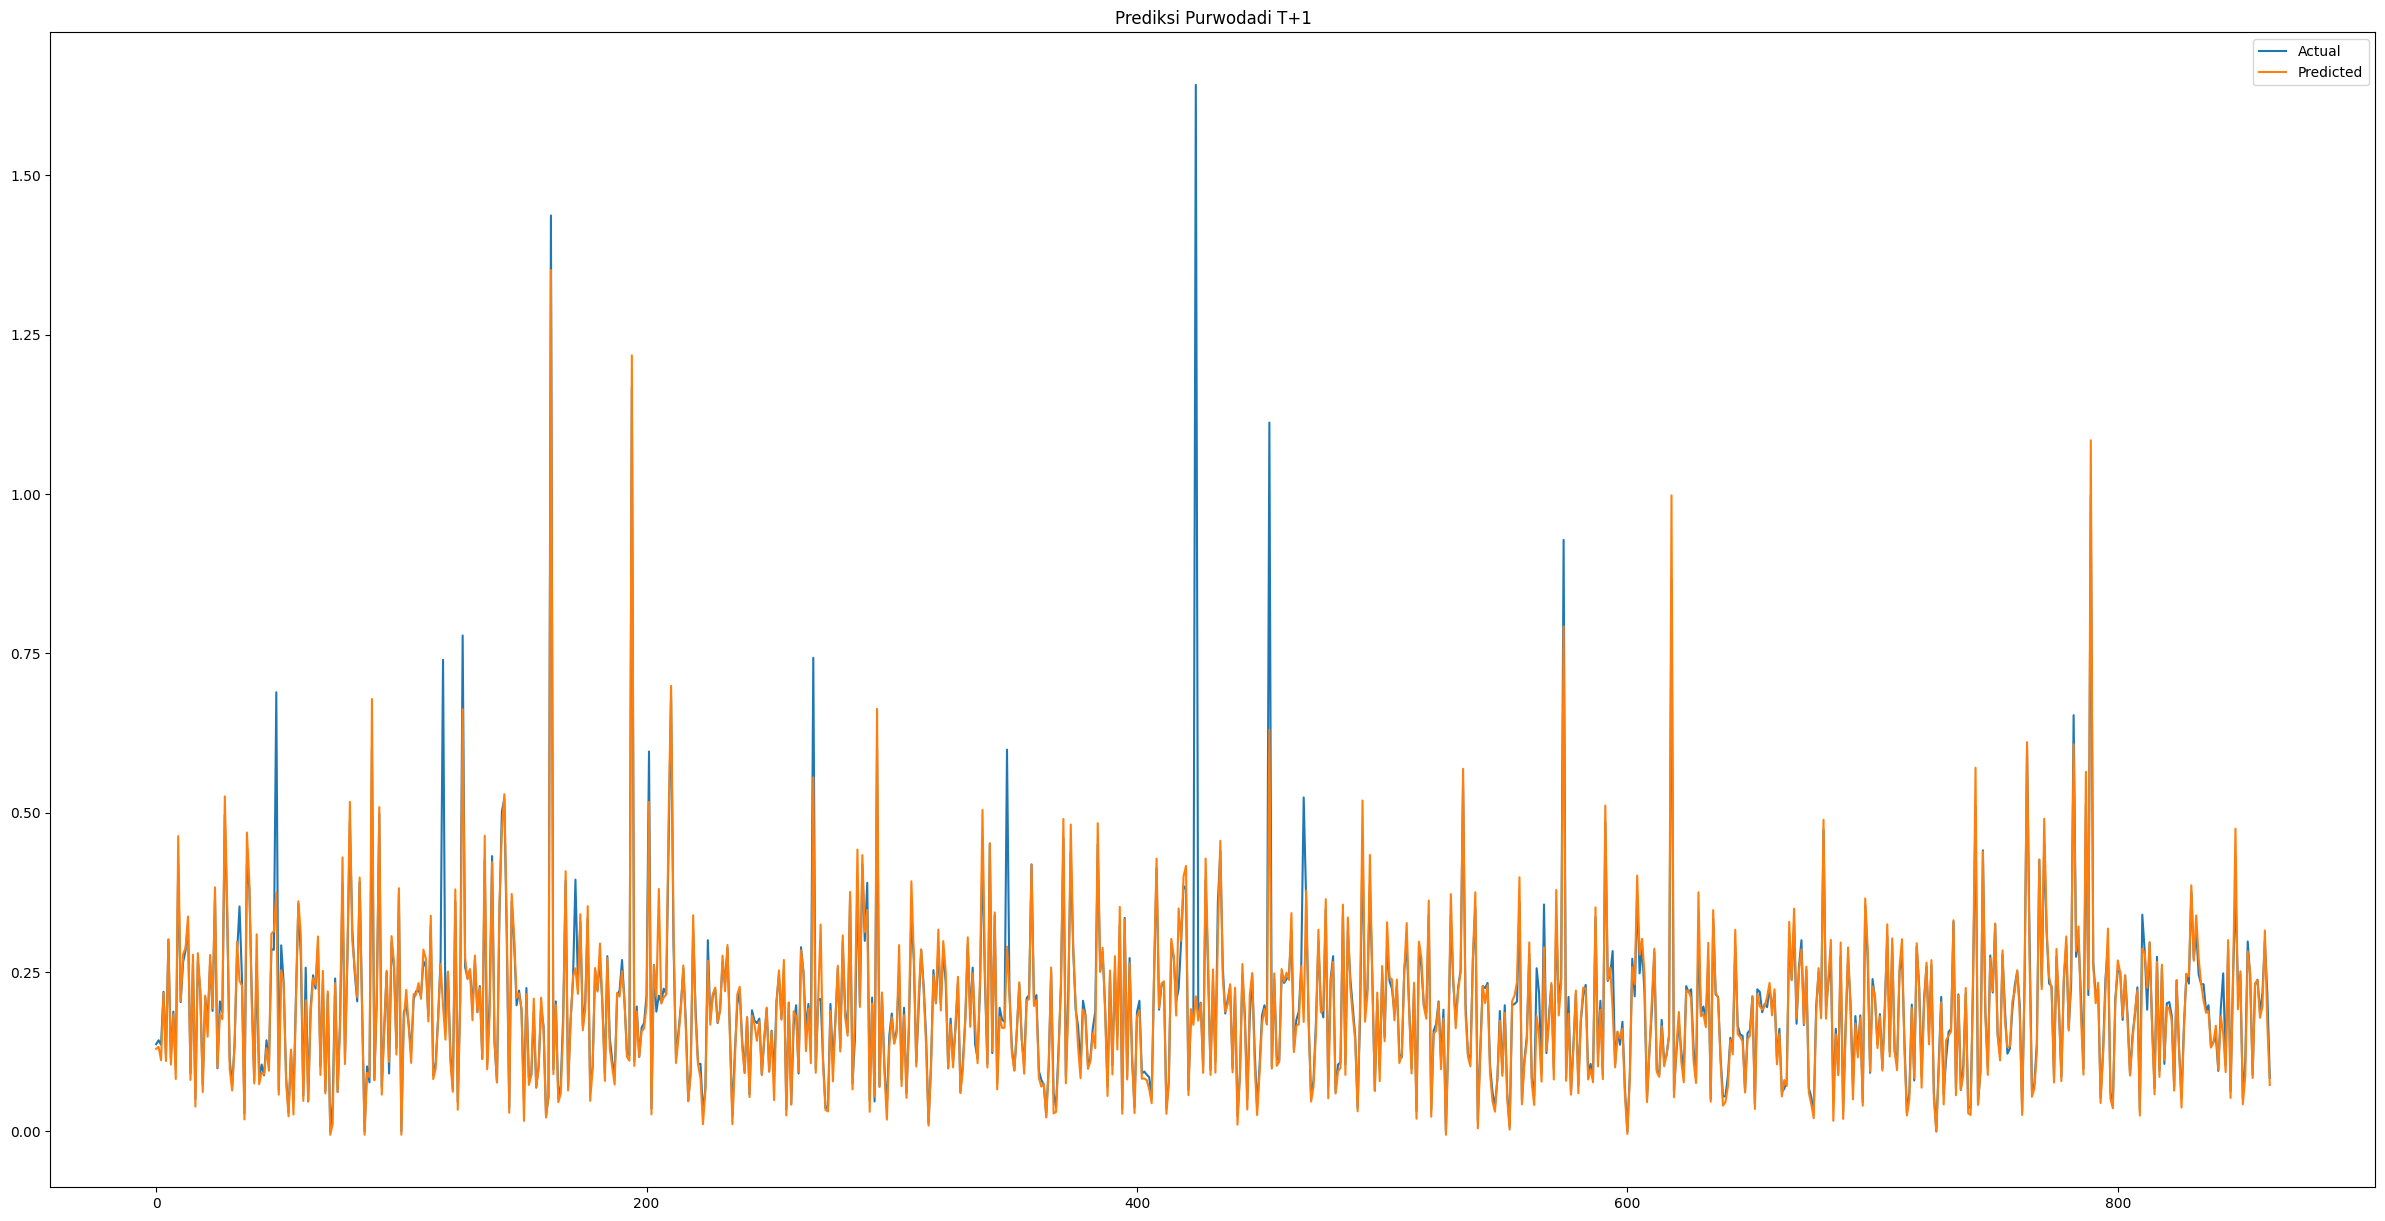

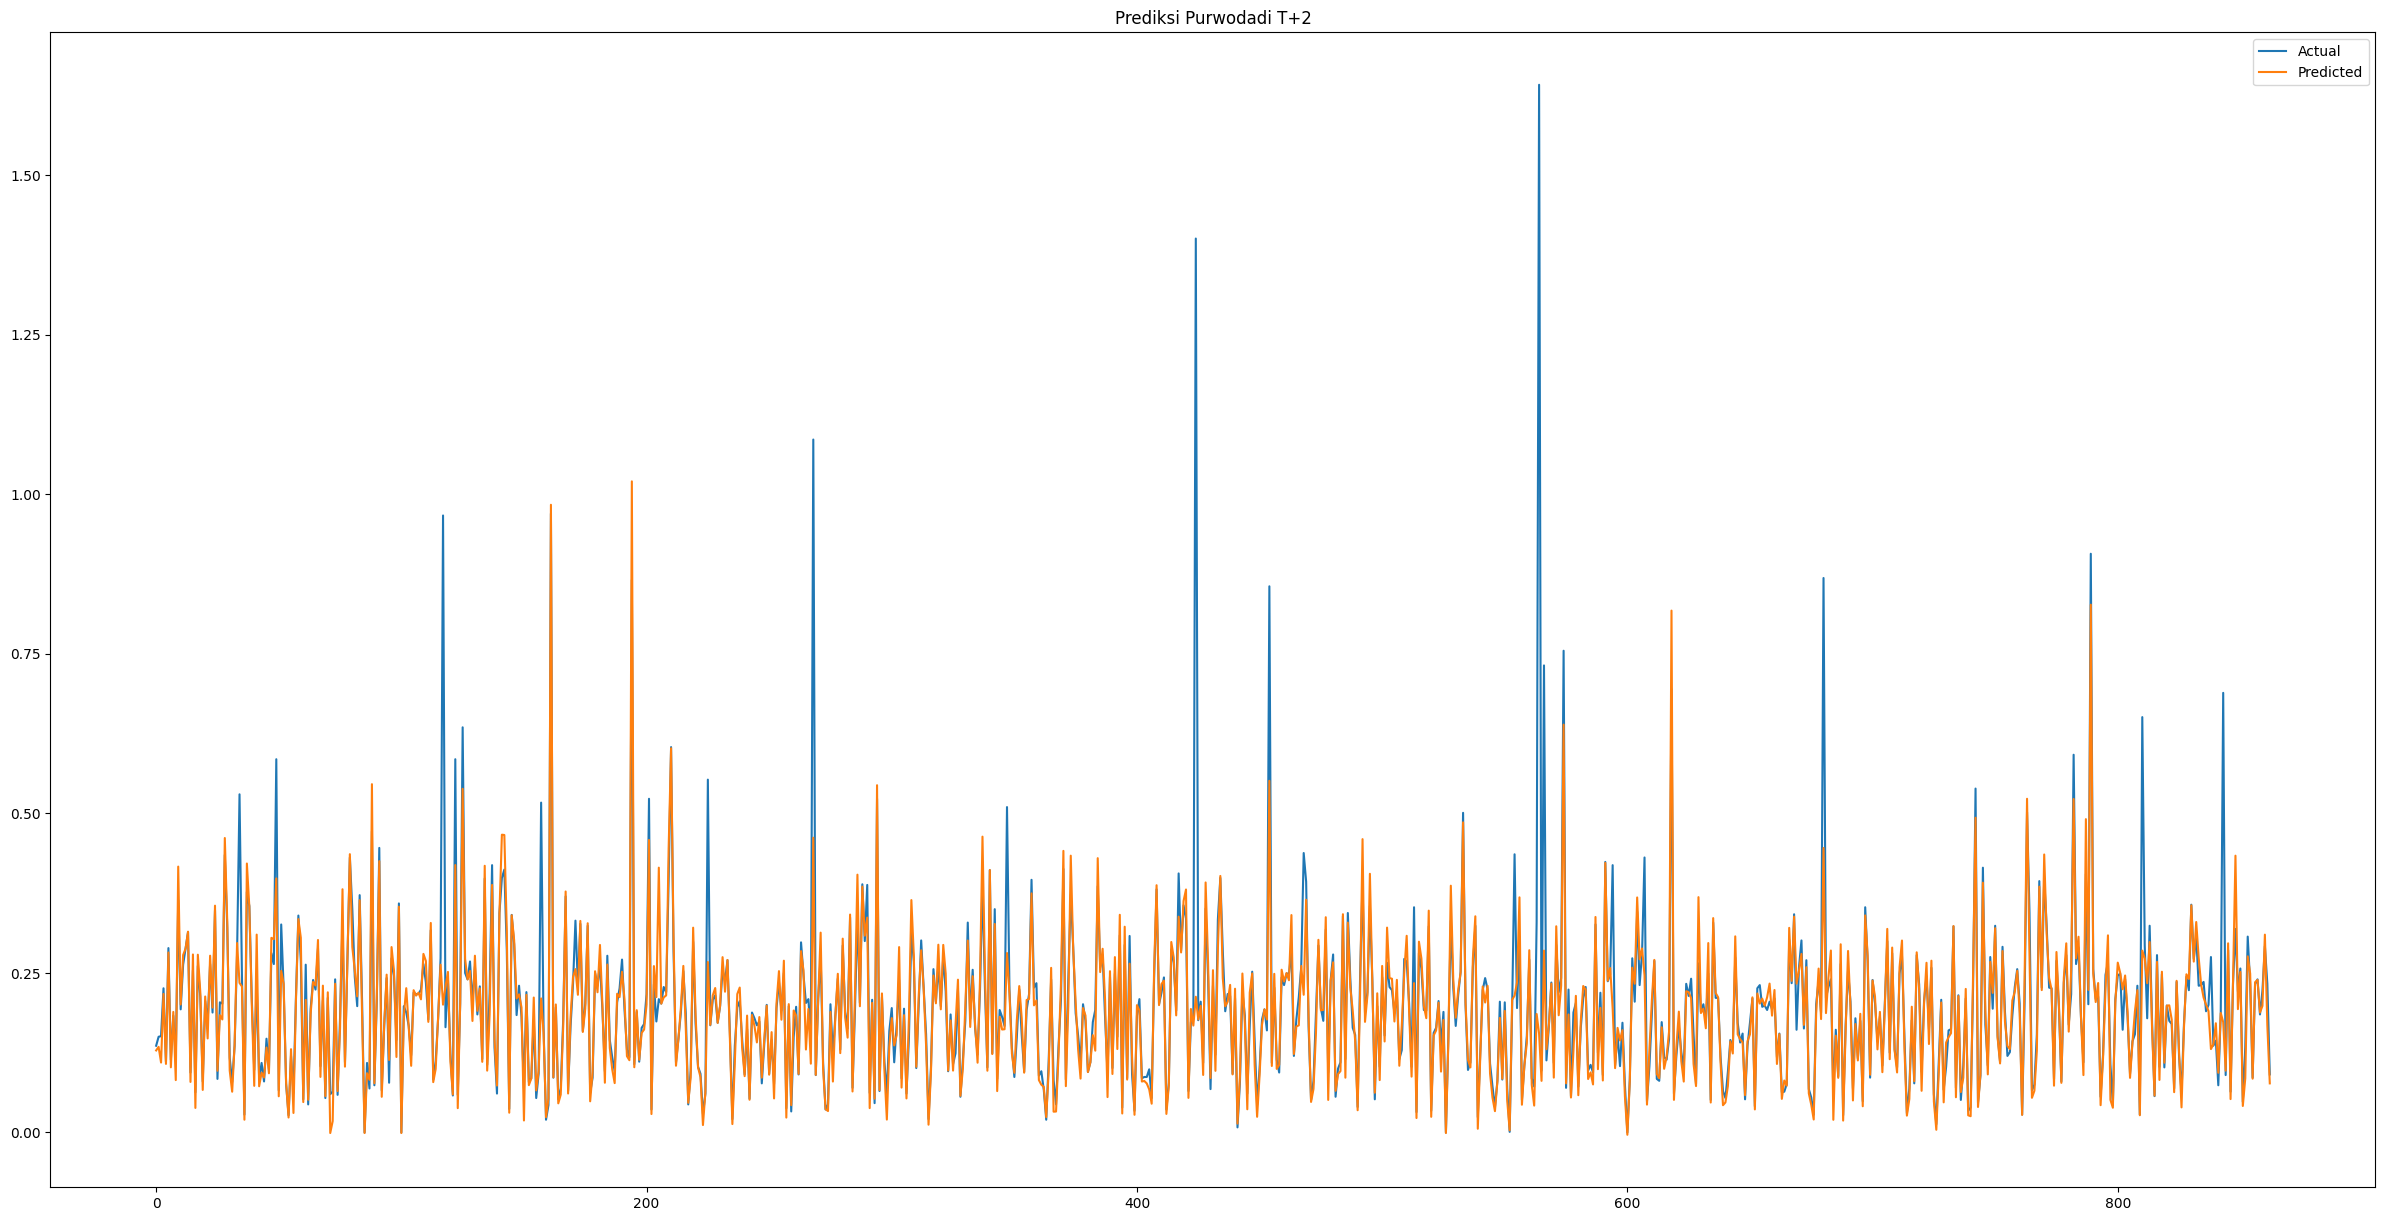

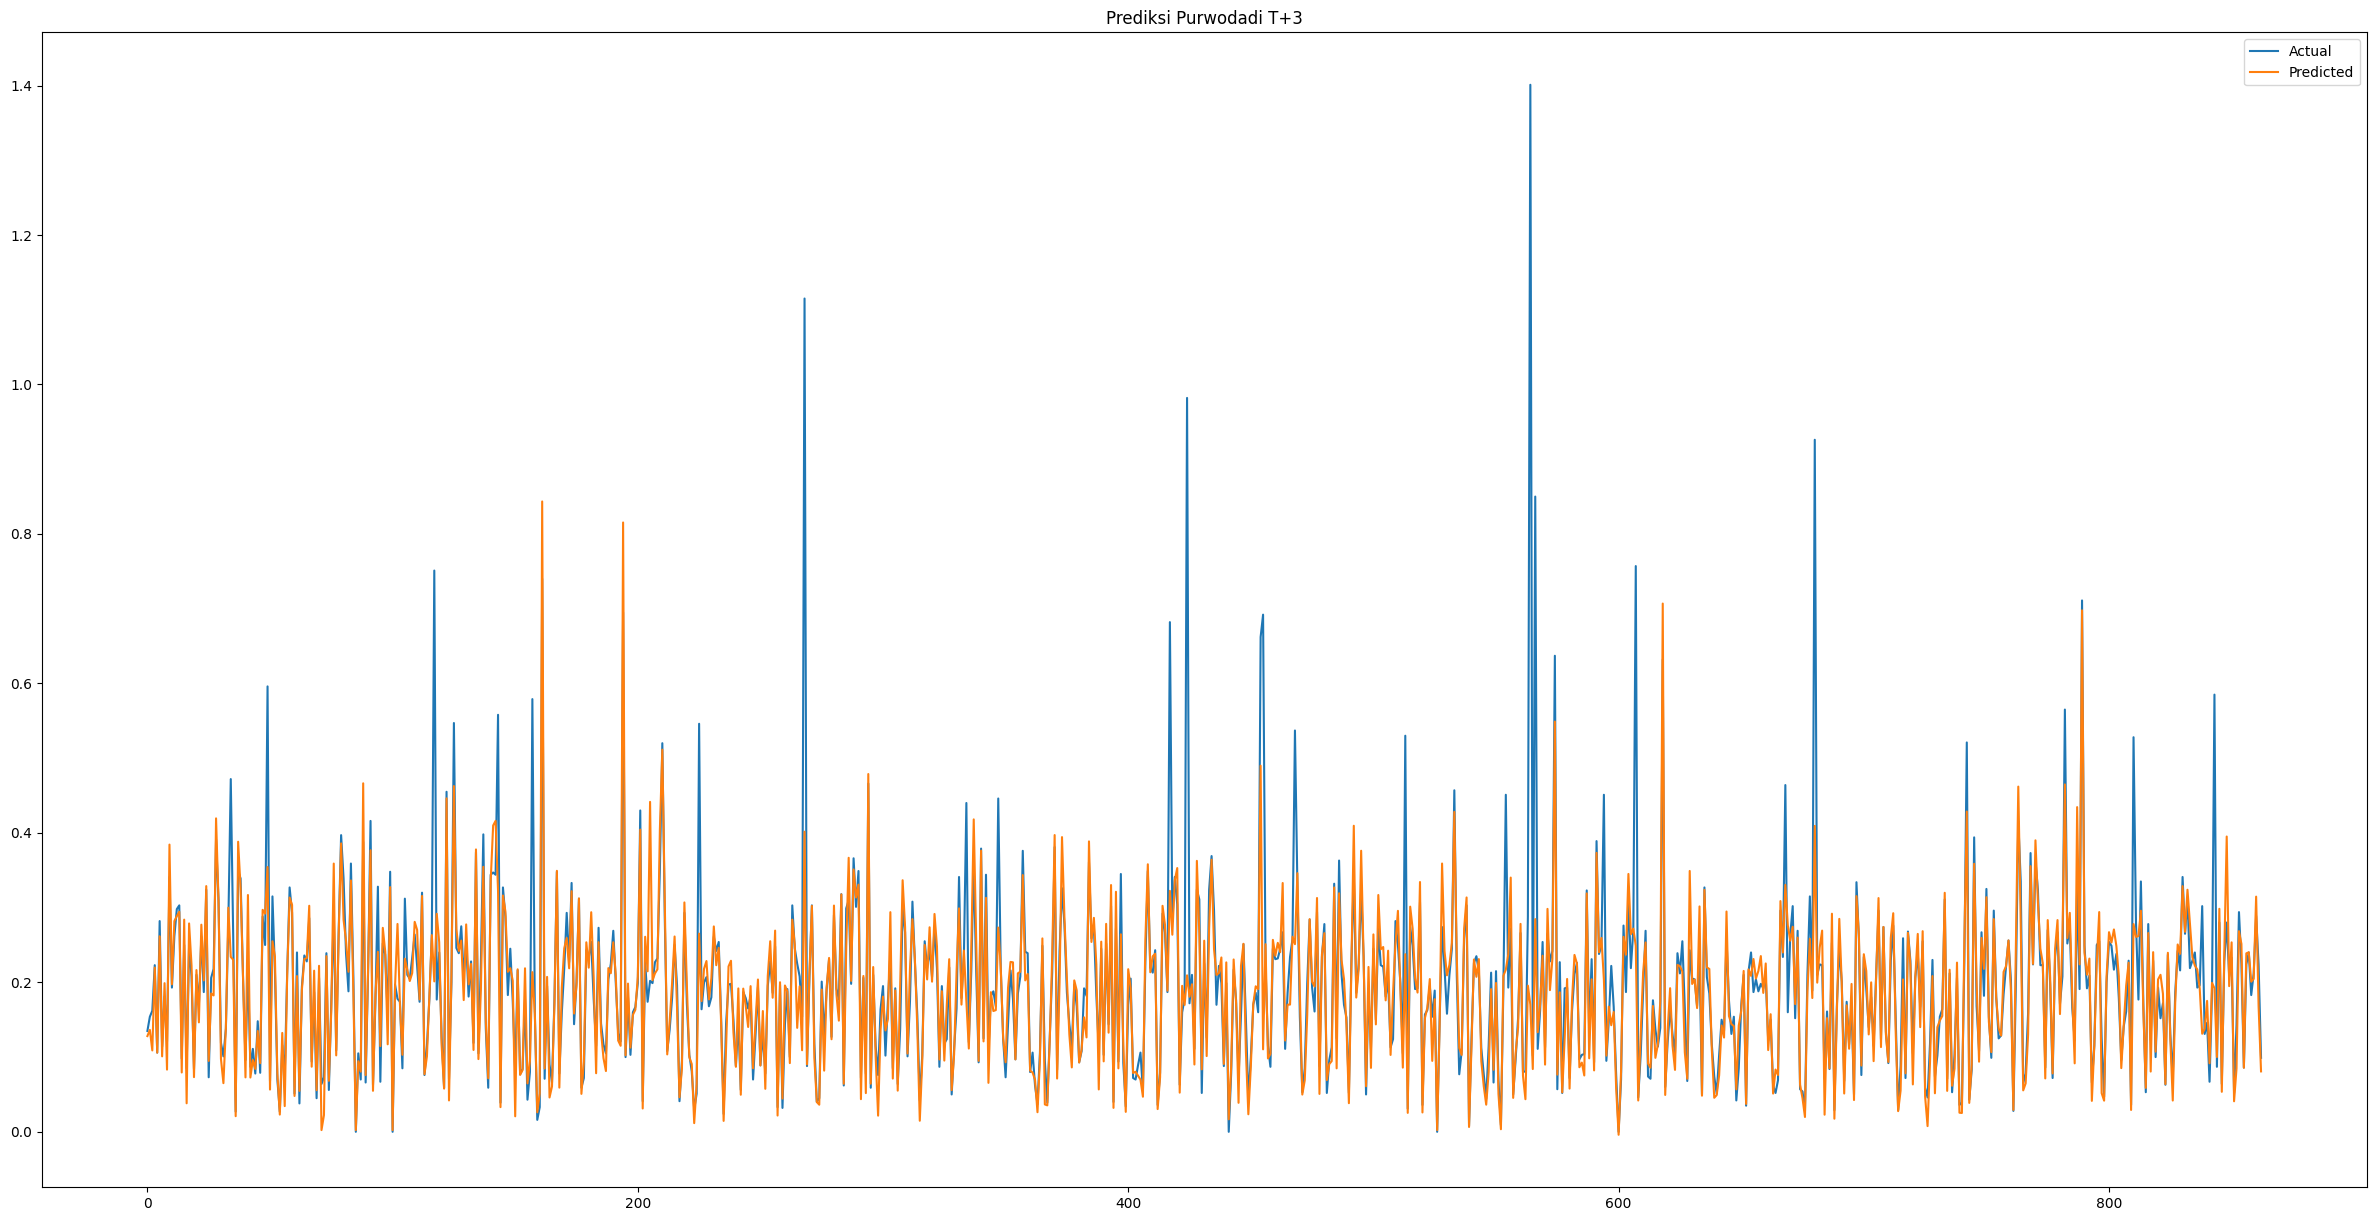

In [34]:
df_final = []
df_final_train = []

for i in range(1, n_steps_out+1):
    df_final.append(pd.DataFrame())
    df_final_train.append(pd.DataFrame())

for i in range(0,n_steps_out):
    df_final[i]['Tinggi Muka Air Purwodadi'] = real[i]
    df_final[i]['Prediksi Tinggi Muka Air Purwodadi'] = predictions[i]
    df_final_train[i]['Tinggi Muka Air Purwodadi'] = real_train[i]
    df_final_train[i]['Prediksi Tinggi Muka Air Purwodadi'] = predictions_for_train[i]

    mpl.rcParams['figure.figsize'] = (30, 15)
    mpl.rcParams['axes.grid'] = False
    ax = df_final[i][['Tinggi Muka Air Purwodadi', 'Prediksi Tinggi Muka Air Purwodadi']].plot()
    ax.legend(["Actual", "Predicted"]) 
    ax.set_title(f"Prediksi Purwodadi T+{i+1}")

    plt.show()

# Plot Model Train Dataset

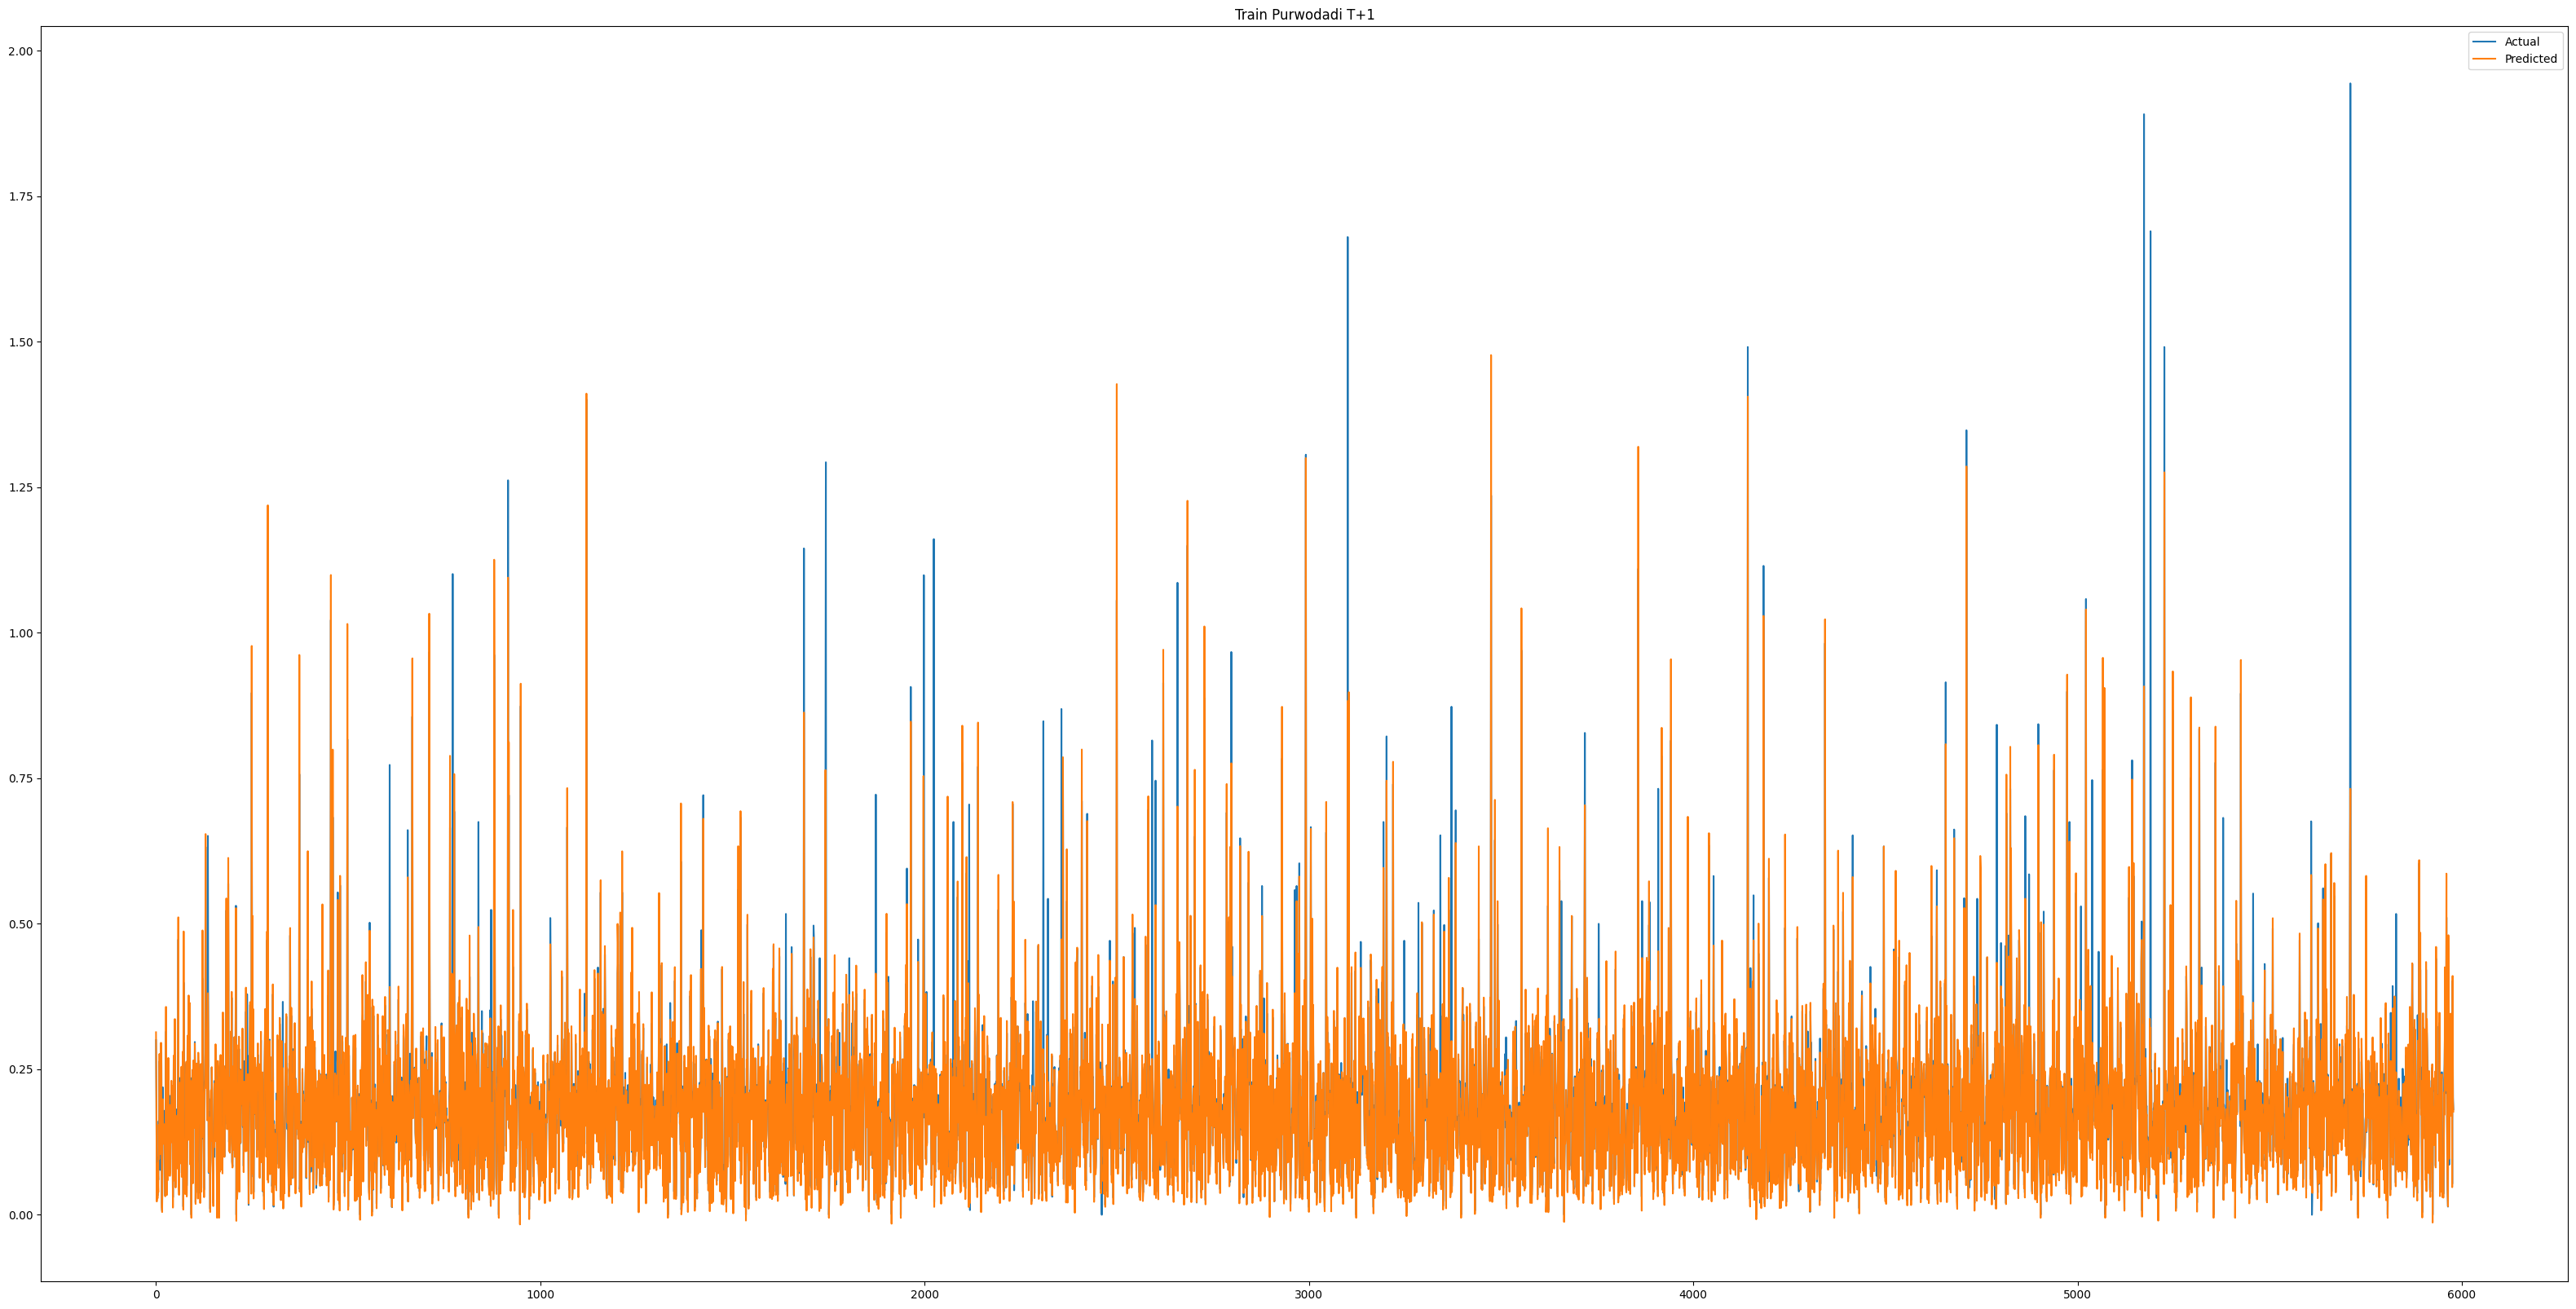

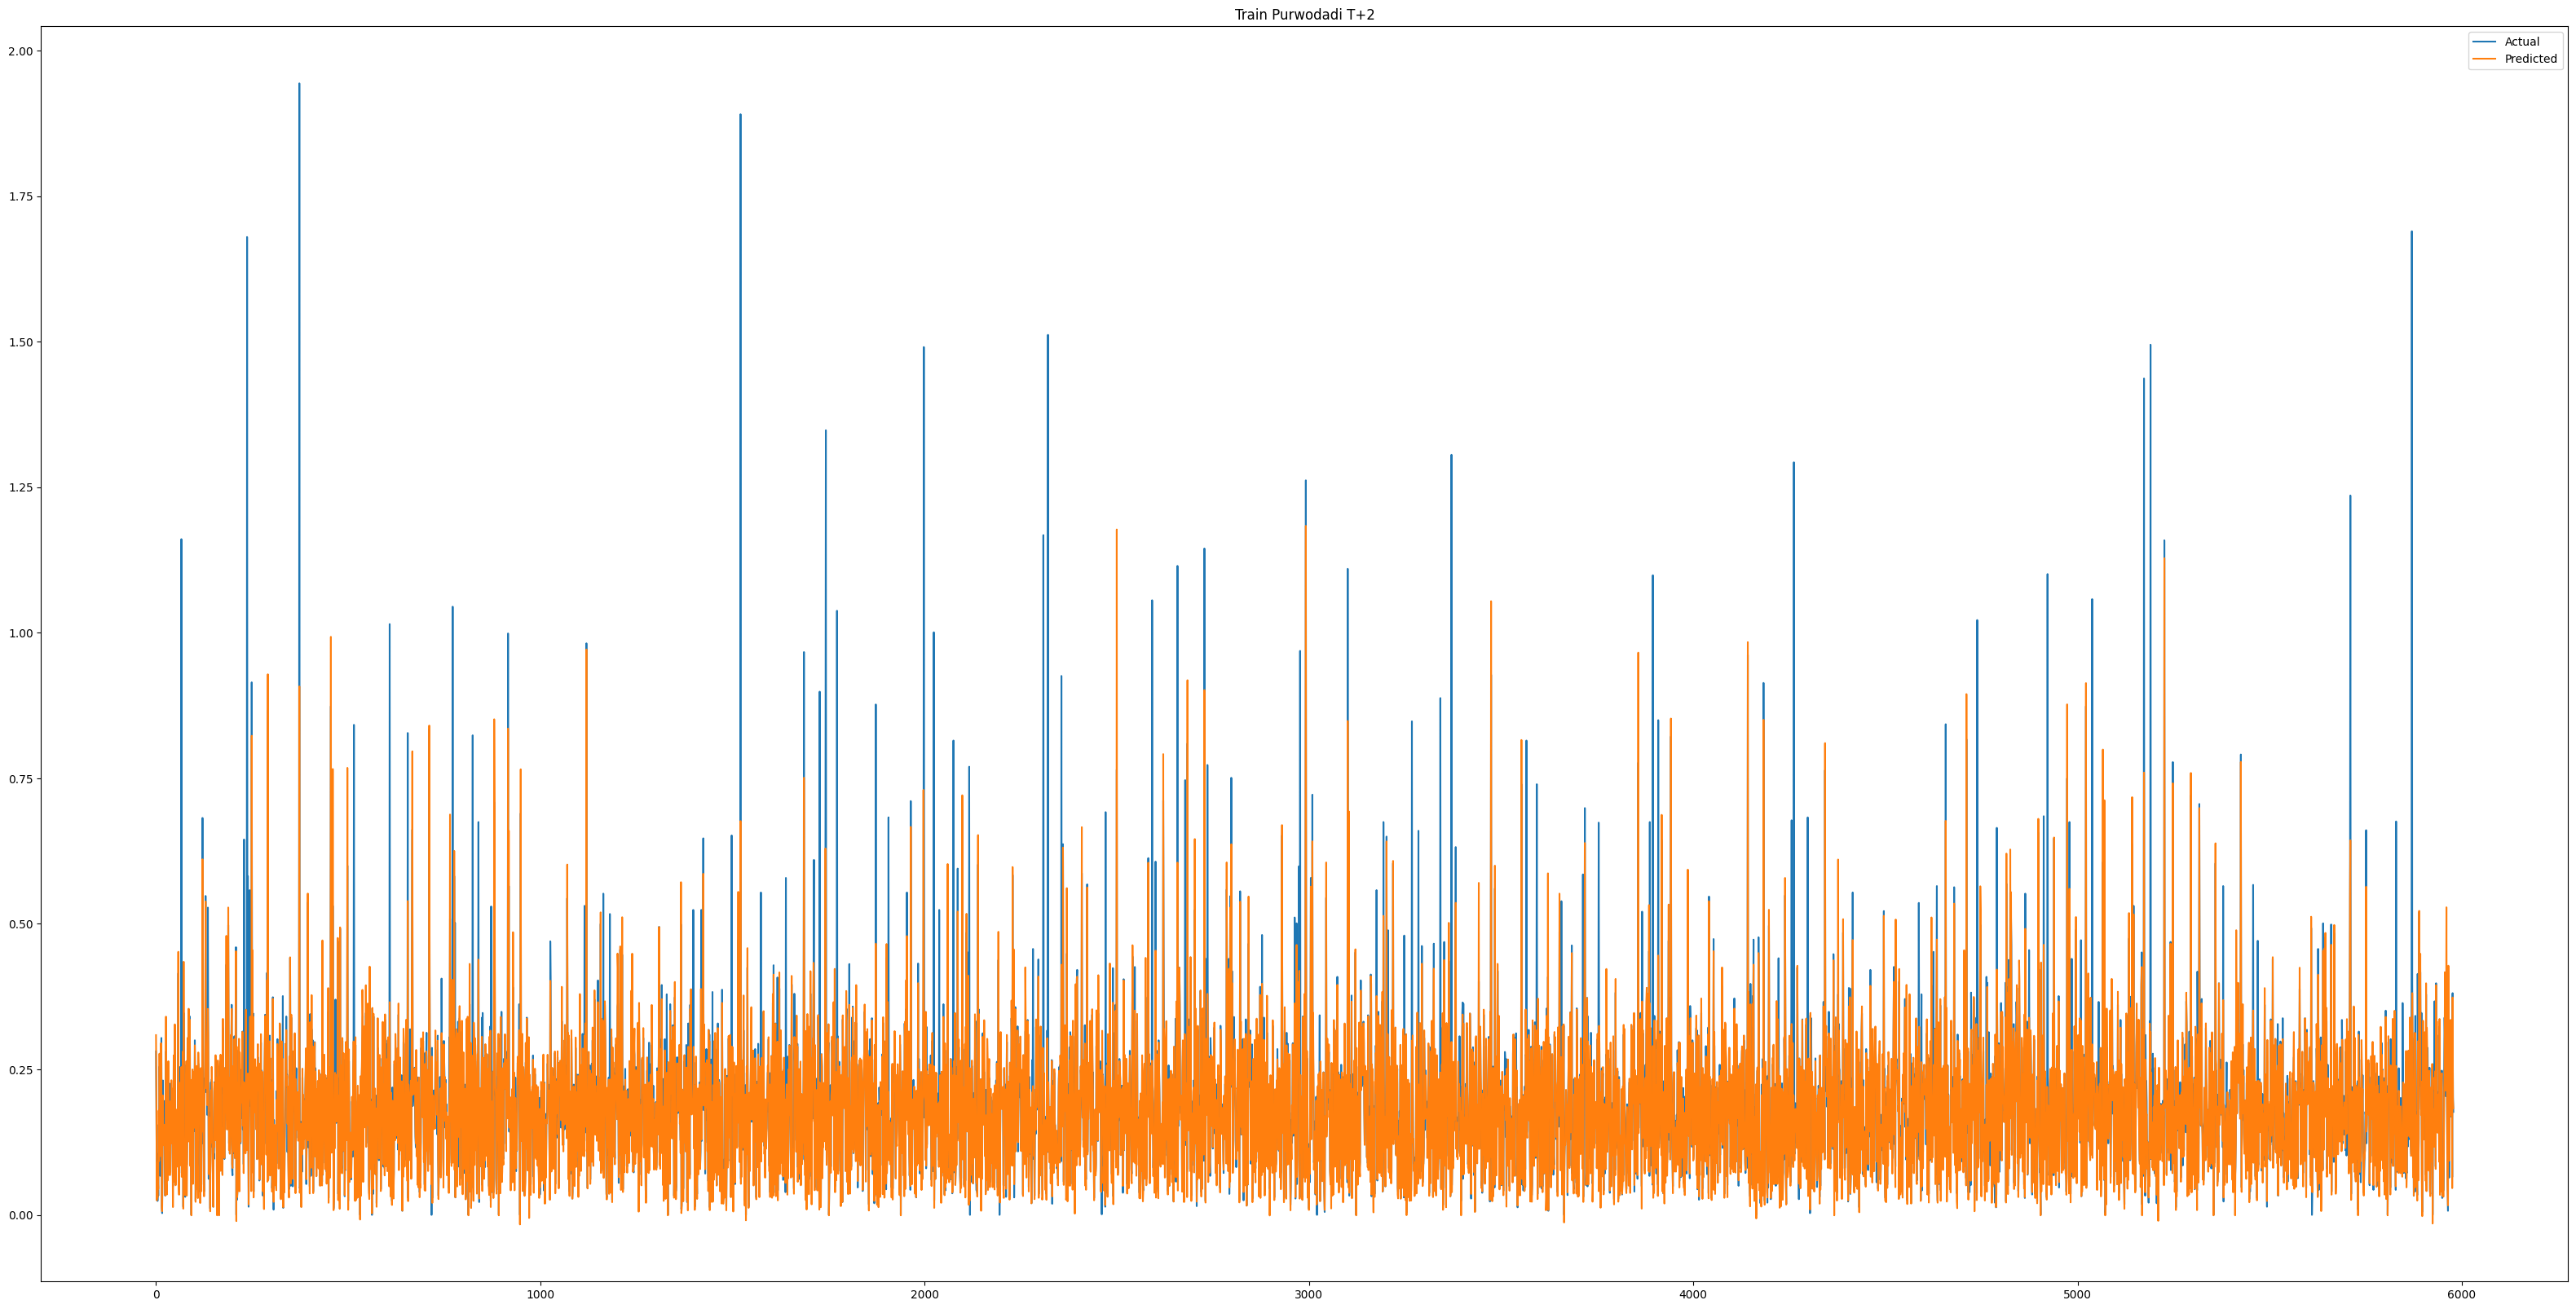

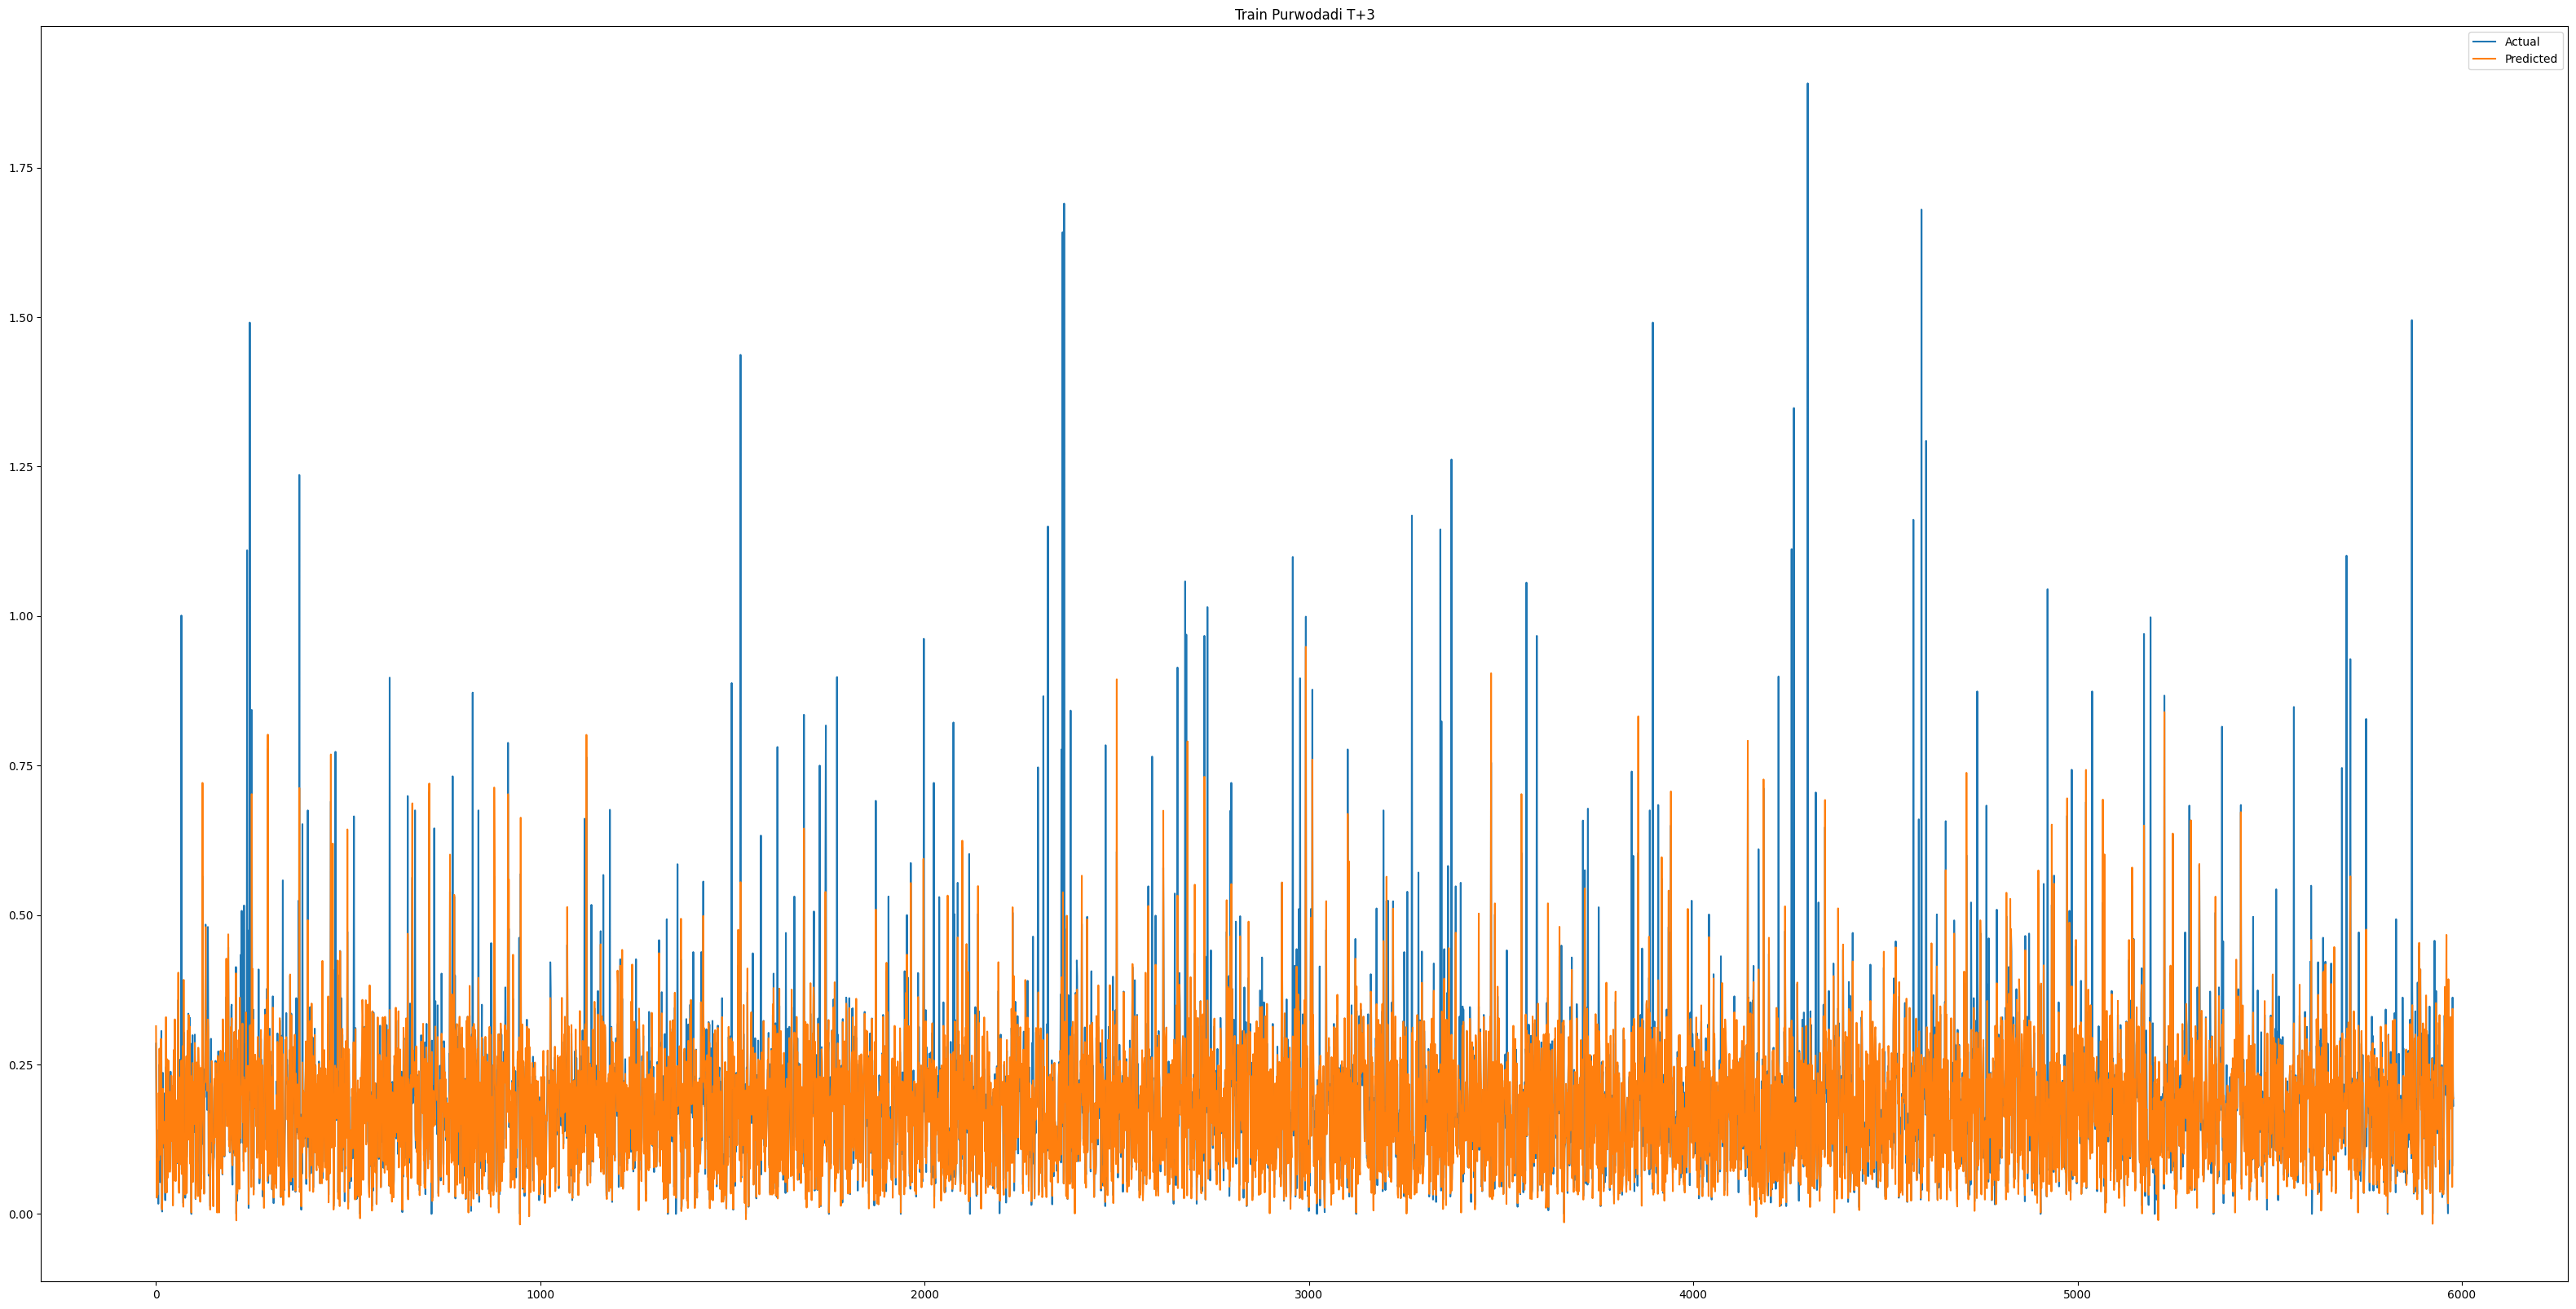

In [35]:
for i in range(0,n_steps_out):
    mpl.rcParams['figure.figsize'] = (40,20)
    mpl.rcParams['axes.grid'] = False
    ax = df_final_train[i][['Tinggi Muka Air Purwodadi', 'Prediksi Tinggi Muka Air Purwodadi']].plot()
    ax.legend(["Actual", "Predicted"]) 
    ax.set_title(f"Train Purwodadi T+{i+1}")

# Evaluation Score

In [36]:
rmse_scores = []
model_names = []
mse_scores = []
mape_scores = []
mae_scores = []

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_percentage_error

indicator = ['Tinggi Muka Air Purwodadi']

for j in range(0,n_steps_out): 
  for i in indicator:
    rmse_scores.append(mean_squared_error(df_final[j][f'{i}'],df_final[j][f'Prediksi {i}'], squared=False))
    mse_scores.append(mean_squared_error(df_final[j][f'{i}'],df_final[j][f'Prediksi {i}']))
    mae_scores.append(mean_absolute_error(df_final[j][f'{i}'], df_final[j][f'Prediksi {i}']))
    mape_scores.append(mean_absolute_percentage_error(df_final[j][f'{i}'], df_final[j][f'Prediksi {i}']))
    model_names.append(f"{i} T+{j+1}")

In [38]:
if all(len(arr) == len(model_names) for arr in [rmse_scores, mse_scores, mae_scores, mape_scores]):
    data = {'Fitur Yang Akan Diprediksi': model_names,
            'RMSE Score Prediction': rmse_scores,
            'MSE Score Prediction': mse_scores,
            'MAE Score Prediction': mae_scores,
            'MAPE Score Prediction': mape_scores}

    df_evaluation = pd.DataFrame(data)
    df_evaluation = df_evaluation.sort_values(by='RMSE Score Prediction', ascending=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    df_evaluation
else:
    print("Arrays have different lengths.")

In [39]:
df_evaluation

,Fitur Yang Akan Diprediksi,RMSE Score Prediction,MSE Score Prediction,MAE Score Prediction,MAPE Score Prediction
0,Tinggi Muka Air Purwodadi T+1,0.06,0.00,0.02,129784292324.80
2,Tinggi Muka Air Purwodadi T+3,0.08,0.01,0.03,144659965413.45
1,Tinggi Muka Air Purwodadi T+2,0.09,0.01,0.03,31656278583.30


In [40]:
df_evaluation.to_excel('Purwodadi_TCN_Predict_T+3.xlsx')

# Perbandingan Selisih Dalam Angka

In [41]:
for i in range(0,n_steps_out):
    df_final[i] = df_final[i].round(2)
    df_final[i][f"Difference_Rerata Tinggi Muka Air T+{i+1} dan Prediksi Tinggi Muka Air T+{i+1}"] = abs(df_final[i]['Tinggi Muka Air Purwodadi'] - df_final[i]['Prediksi Tinggi Muka Air Purwodadi'])

In [42]:
df_final[0]

,Tinggi Muka Air Purwodadi,Prediksi Tinggi Muka Air Purwodadi,Difference_Rerata Tinggi Muka Air T+1 dan Prediksi Tinggi Muka Air T+1
0,0.14,0.13,0.01
1,0.14,0.13,0.01
2,0.14,0.11,0.03
3,0.22,0.22,0.00
4,0.12,0.11,0.01
...,...,...,...
858,0.19,0.18,0.01
859,0.22,0.20,0.02
860,0.30,0.32,0.02
861,0.22,0.17,0.05


# Save Model

In [46]:
model.save_weights('./checkpoints/my_checkpoint')

In [43]:
!mkdir -p saved_model
model.save('saved_model/purwodadi_tcn')
model.save('purwodadi_tcn.h5')

INFO:tensorflow:Assets written to: saved_model/purwodadi_tcn/assets


INFO:tensorflow:Assets written to: saved_model/purwodadi_tcn/assets


In [44]:
import pickle
with open('purwodadi_tcn_x_scaler.pkl', 'wb') as file:
    pickle.dump(x_scaler, file)
    
with open('purwodadi_tcn_y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)